In [1]:
from torch.utils.data import Dataset
import scipy
import os
from PIL import Image

## Oxford 102 Flower Data set

Image and labels are accessible at: [https://www.robots.ox.ac.uk/%7Evgg/data/flowers/102/](https://www.robots.ox.ac.uk/%7Evgg/data/flowers/102/)

In [2]:
# When building a dataset, you need a data class. It needs to answer 3 questions.

class OxfordFlowersDataset(Dataset):

    # Setup: where to find images and labels
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'jpg')

        # load matlab labels
        labels_mat = scipy.io.loadmat(
            os.path.join(root_dir, 'imagelabels.mat')
        )

        # make it zero index
        self.labels = labels_mat['labels'][0] - 1

    # How many total samples
    def __len__(self):
        return len(self.labels) 

    # How to get image and label number 'idx'
    def __getitem__(self, idx):
        
        # Build the image file name
        img_name = f'image_{idx+1:05d}.jpg'
        img_path = os.path.join(self.img_dir, img_name)

        # load the image
        image = Image.open(img_path)
        label = self.labels[idx]

        return image, label

In [3]:
dataset = OxfordFlowersDataset(root_dir = './data')

In [4]:
# how many labels?
len(dataset)

8189

In [5]:
image, label = dataset[10]

In [6]:
print(f'This is an image of: {label}')

This is an image of: 76


In [7]:
from matplotlib import pyplot as plt

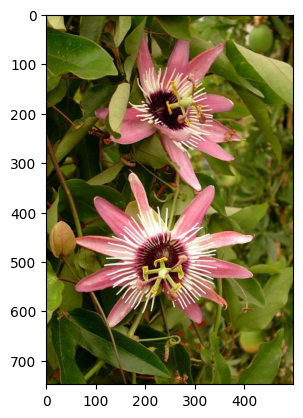

In [8]:
plt.imshow(image)

## Transformation Pipleline

2 main issues:
* Images are of different size
* Return type is a PIL Image and not a tensor

In [9]:
from torchvision import transforms

In [10]:
img, _ = dataset[0]
resized = transforms.Resize(256)(img)
print(f"After resize: {resized.size}")
cropped = transforms.CenterCrop(224)(resized)
print(f"After cropping: {cropped.size}")

After resize: (302, 256)
After cropping: (224, 224)


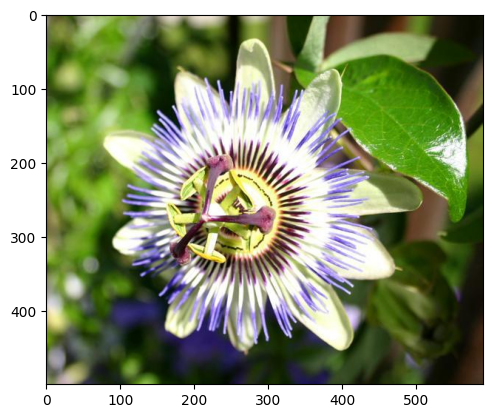

In [11]:
plt.imshow(img)

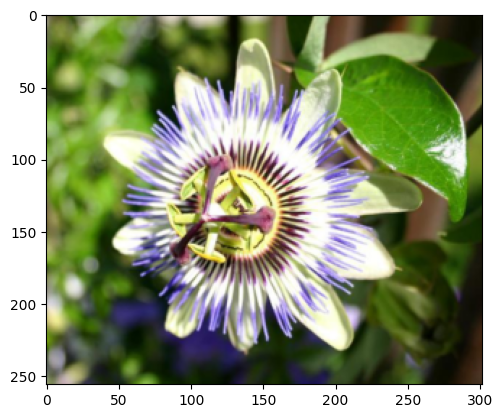

In [12]:
plt.imshow(resized)

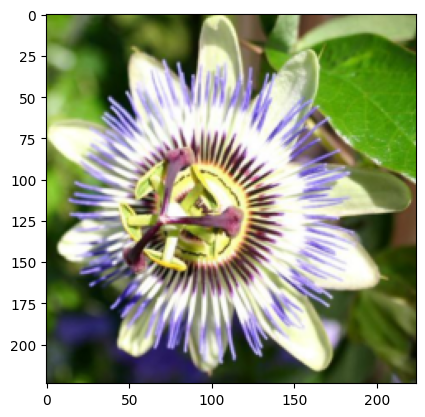

In [13]:
plt.imshow(cropped)

## Data Pipeline

Let's explore the reason for building a data pipeline.

In [14]:
from torch.utils.data import DataLoader

In [15]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True) 

# try to get a batch - this will fail
for images, labels in dataloader:
    print(f"Batch shape: {images.shape}")
    break

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>

In [16]:
# let's see the size of the images - maybe they have different height and size.
for i in [0, 100, 500]:
    img, _ = dataset[i]
    print(f"Image {i}: {img.size} and type: {type(img)}")

Image 0: (591, 500) and type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Image 100: (588, 500) and type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Image 500: (667, 500) and type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


In [24]:
img, _ = dataset[0]
img_tensor = transforms.ToTensor()(img)
print(f"Tensor size: {img_tensor.shape}")
print(img_tensor[0, :3, :3])

Tensor size: torch.Size([3, 500, 591])
tensor([[0.4941, 0.4863, 0.4745],
        [0.4980, 0.4902, 0.4784],
        [0.5098, 0.5020, 0.4863]])


In [27]:
temp = transforms.Resize(256)(img)
temp = transforms.CenterCrop(224)(temp)
temp = transforms.ToTensor()(temp)
temp = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std =[0.229, 0.224, 0.225])(temp)
print(temp)

tensor([[[-0.4568, -0.4739, -0.4739,  ...,  0.1426,  0.1426,  0.0912],
         [-0.4397, -0.4739, -0.4739,  ...,  0.2282,  0.2453,  0.2624],
         [-0.3883, -0.4226, -0.4568,  ...,  0.3652,  0.3481,  0.3309],
         ...,
         [-1.2959, -1.2959, -1.3130,  ..., -1.3815, -1.4158, -1.4500],
         [-1.3815, -1.3815, -1.3644,  ..., -1.3302, -1.2959, -1.3130],
         [-1.4500, -1.4500, -1.4500,  ..., -1.1075, -1.0733, -1.1247]],

        [[ 0.4853,  0.5203,  0.5728,  ...,  0.5203,  0.5028,  0.4328],
         [ 0.5378,  0.5553,  0.5903,  ...,  0.6954,  0.6604,  0.6078],
         [ 0.5903,  0.5728,  0.5903,  ...,  0.8529,  0.8179,  0.7654],
         ...,
         [-1.0028, -1.0028, -1.0028,  ..., -1.1954, -1.2129, -1.2479],
         [-1.0903, -1.0903, -1.1253,  ..., -1.0553, -1.0553, -1.1429],
         [-1.1779, -1.1779, -1.1954,  ..., -0.8277, -0.8452, -0.9678]],

        [[-1.4733, -1.5256, -1.5953,  ..., -0.3578, -0.3578, -0.4101],
         [-1.4559, -1.5430, -1.5779,  ..., -0

We have 2 problems with the original method

* Image sizes are not consistant. We can't work with this - we need all images to be of same size.
* Data format should be a tensor and not a PIL image.

By using `ToTensor`, we convert the data type to a tensor, scale the value between 0 and 1.

## Solution
We'll resize the image, centercrop it and then normalize the value

In [21]:
# let's resize by just providing one value. It will resize based on the larger dimension and then let's center crop the image.

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), # normlize will work not work on image
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std =[0.229, 0.224, 0.225])
    ]
)

In [28]:
# When building a dataset, you need a data class. It needs to answer 3 questions.

class OxfordFlowersDataset(Dataset):

    # Setup: where to find images and labels
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'jpg')

        # load matlab labels
        labels_mat = scipy.io.loadmat(
            os.path.join(root_dir, 'imagelabels.mat')
        )

        # make it zero index
        self.labels = labels_mat['labels'][0] - 1

        # set the trasformation pipeline
        self.transform = transform

    # How many total samples
    def __len__(self):
        return len(self.labels) 

    # How to get image and label number 'idx'
    def __getitem__(self, idx):
        
        # Build the image file name
        img_name = f'image_{idx+1:05d}.jpg'
        img_path = os.path.join(self.img_dir, img_name)

        # load the image
        image = Image.open(img_path)
        label = self.labels[idx]

        # return the right kind of object
        if self.transform:
            image = self.transform(image)

        return image, label

In [29]:
# now there shouldn't be any error
dataset = OxfordFlowersDataset(root_dir = './data')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True) 

# try to get a batch - this will fail
for images, labels in dataloader:
    print(f"Batch shape: {images.shape}")
    break

Batch shape: torch.Size([4, 3, 224, 224])
